In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.facecolor']='w'
import matplotlib.animation as animation 
from matplotlib.animation import PillowWriter
from numba import njit
from matplotlib import colors as mcolors

In [2]:
@njit
def simulate(L, iterations, zc):
    
    z = np.zeros(shape=(L+2,L+2))
    N = L**2
    z_new = np.zeros(shape=(iterations,L,L))
    z_avg = np.zeros(iterations)
    z_std = np.zeros(iterations)

    for i in range(iterations):
        for j in range(L):
            for k in range(L):
                z_new[i][j][k] = z[j+1][k+1]
        if np.max(z_new[i]) > zc:
            for j in range(1,L+1):
                for k in range(1,L+1):
                    if z[j][k]>zc:
                        z[j][k] += -4
                        z[j-1][k] += 1
                        z[j+1][k] += 1
                        z[j][k-1] += 1
                        z[j][k+1] += 1
        else:
            randsite_x = int(np.random.uniform(0,1)*L+1)   # Chooses a random integer between 0 and L
            randsite_y = int(np.random.uniform(0,1)*L+1)   # Chooses a random integer between 0 and L
            z[randsite_x][randsite_y] += 1
        
        z_avg[i] = np.mean(z_new[i])
        z_std[i] = np.std(z_new[i])

    return z_new, z_avg, z_std

In [3]:
# @njit
def simulate1(L, iterations, zc):
    
    z = np.zeros(shape=(L+2,L+2))
    N = L**2
    z_new = np.zeros(shape=(iterations,L,L))
    z_avg = np.zeros(iterations)
    z_std = np.zeros(iterations)

    for i in range(iterations):
                
        # Adding grain
        randsite_x = int(np.random.uniform(0,1)*L+1)   # Chooses a random integer between 0 and L
        randsite_y = int(np.random.uniform(0,1)*L+1)   # Chooses a random integer between 0 and L
        z[randsite_x][randsite_y] += 1
        
        #Toppling
        parents_no = 1
        parent_sites = np.array([[randsite_x, randsite_y]])
        while parents_no > 0:
            children_no = 0
            children_sites = np.zeros(shape=(parents_no*4,2), dtype=int)
            for p in range(parents_no):
                if z[parent_sites[p][0]][parent_sites[p][1]] > zc:
                    
                    z[parent_sites[p][0]][parent_sites[p][1]] += -4
                    
                    if parent_sites[p][0]>0:
                        children_no += 1
                        children_sites[int(4*p)+0] = [parent_sites[p][0]-1, parent_sites[p][1]]
#                         print(type(children_sites[int(4*p)+0][0]))
                        z[children_sites[int((4*p)+0)][0]][children_sites[int(4*p)+0][1]] += 1
                    
                    if parent_sites[p][0]<L+1:
                        children_no += 1
                        children_sites[int(4*p)+1] = [parent_sites[p][0]+1, parent_sites[p][1]]
                        z[children_sites[int(4*p)+1][0]][children_sites[int(4*p)+1][1]] += 1
                    
                    if parent_sites[p][1]>0:
                        children_no += 1
                        children_sites[int(4*p)+2] = [parent_sites[p][0], parent_sites[p][1]-1]
                        z[children_sites[int(4*p)+2][0]][children_sites[int(4*p)+2][1]] += 1
                    
                    if parent_sites[p][1]<L+1:
                        children_no += 1
                        children_sites[int(4*p)+3] = [parent_sites[p][0], parent_sites[p][1]+1]
                        z[children_sites[int(4*p)+3][0]][children_sites[int(4*p)+3][1]] += 1

            parent_sites = children_sites
            parents_no = children_no
            
        for j in range(L):
            for k in range(L):
                z_new[i][j][k] = z[j+1][k+1]
        
        z_avg[i] = np.mean(z_new[i])
        z_std[i] = np.std(z_new[i])

    return z_new, z_avg, z_std

In [4]:
# @njit
def simulate2(L, iterations, zc):
    
    z = np.zeros(shape=(L+2, L+2))
    N = L**2
    z_new = np.zeros(shape=(iterations, L, L))
    z_avg = np.zeros(iterations)
    z_std = np.zeros(iterations)
    avalanche = np.zeros(shape=(iterations, L, L))
    av_size = np.zeros(iterations)
    
    # Initial condition
    for j in range(L):
        for k in range(L):
            z_new[0][j][k] = np.random.randint(0,zc+1)

    for i in range(1,iterations):
        
        # Adding grain
        randsite_x = np.random.randint(1, L+1)
        randsite_y = np.random.randint(1, L+1)
        z[randsite_x, randsite_y] += 1
        
        # Toppling
        active_parent_sites = np.array([[randsite_x, randsite_y]])
        while len(active_parent_sites) > 0:
            active_children_sites = []
            for parent_site in active_parent_sites:
                x, y = parent_site
                if z[x, y] > zc:
                    av_size[i] += 1
                    z[x, y] -= 4
                    
                    # Adding grains to neighboring sites
                    neighbors = [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]
                    for neighbor_x, neighbor_y in neighbors:
                        if 1 <= neighbor_x <= L and 1 <= neighbor_y <= L:
                            z[neighbor_x, neighbor_y] += 1
                            active_children_sites.append([neighbor_x, neighbor_y])

            active_parent_sites = active_children_sites

        # Storing the current state
        z_new[i] = z[1:L+1, 1:L+1]
        z_avg[i] = np.mean(z_new[i])
        z_std[i] = np.std(z_new[i])
        
        avalanche[i] = z_new[i]-z_new[i-1]

    return z_new, avalanche, z_avg, z_std, av_size

In [5]:
a = -np.ones(10)
b = np.where(a>-1)
print(b)

(array([], dtype=int64),)


In [6]:
@njit
def simulate3(L, iterations, zc):
    
    z = np.zeros((L+2, L+2), dtype=np.int64)
    z_new = np.zeros((iterations, L, L), dtype=np.int64)
    z_avg = np.zeros(iterations)
    z_std = np.zeros(iterations)
    avalanche = np.zeros((iterations, L, L), dtype=np.int64)
    av_size = np.zeros(iterations, dtype=np.int64)
    
    # Initial condition
    for j in range(L):
        for k in range(L):
            z_new[0][j][k] = np.random.randint(0, zc+1)

    for i in range(1, iterations):
        
        # Adding grain
        randsite_x = np.random.randint(1, L+1)
        randsite_y = np.random.randint(1, L+1)
        z[randsite_x, randsite_y] += 1
        
        # Toppling
                # Toppling
        active_parent_sites = np.zeros((L*L, 2), dtype=np.int64)
        active_parent_sites[0] = [randsite_x, randsite_y]
        active_parent_index = 1
        
        while active_parent_index > 0:
            active_children_sites = np.zeros((L*L*4, 2), dtype=np.int64)
            active_children_index = 0
            for p in range(active_parent_index):
                x, y = active_parent_sites[p]
                if z[x, y] > zc:
                    av_size[i] += 1
                    z[x, y] -= 4
                    
                    # Adding grains to neighboring sites
                    neighbors = [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]
                    for neighbor_x, neighbor_y in neighbors:
                        if 1 <= neighbor_x <= L and 1 <= neighbor_y <= L:
                            z[neighbor_x, neighbor_y] += 1
                            active_children_sites[active_children_index] = [neighbor_x, neighbor_y]
                            active_children_index += 1

            active_parent_sites[:active_children_index] = active_children_sites[:active_children_index]
            active_parent_index = active_children_index

        # Storing the current state
        z_new[i] = z[1:L+1, 1:L+1]
        z_avg[i] = np.mean(z_new[i])
        z_std[i] = np.std(z_new[i])
        
        avalanche[i] = z_new[i] - z_new[i-1]

    return z_new, avalanche, z_avg, z_std, av_size


In [7]:
# @njit
def quants(av_size):
    
    n_bins = 200
    dist_size = np.zeros(n_bins)
    dist_size_new = []
    bins_new = []
    
    bin_width = np.max(av_size)/(n_bins-1)
    
    for av in av_size[6000:]:
#         if av<2000:
        bin_index = av/bin_width
        dist_size[int(bin_index)] += 1
    for i in range(n_bins):
        if dist_size[i] > 0:
            dist_size_new.append(dist_size[i])
            bins_new.append(i)
    
    bins_new = np.array(bins_new)
    bins_new = bins_new*bin_width + 1
            
    return bins_new, dist_size_new

In [8]:
%%time
z1, av1, z_avg1, z_std1, av_size1 = simulate3(50, 10000, 3)
# z2, z_avg2, z_std2 = simulate(50, 100000, 3)
# z3, z_avg3, z_std3 = simulate(100, 100000, 3)

CPU times: total: 3.7 s
Wall time: 6.75 s


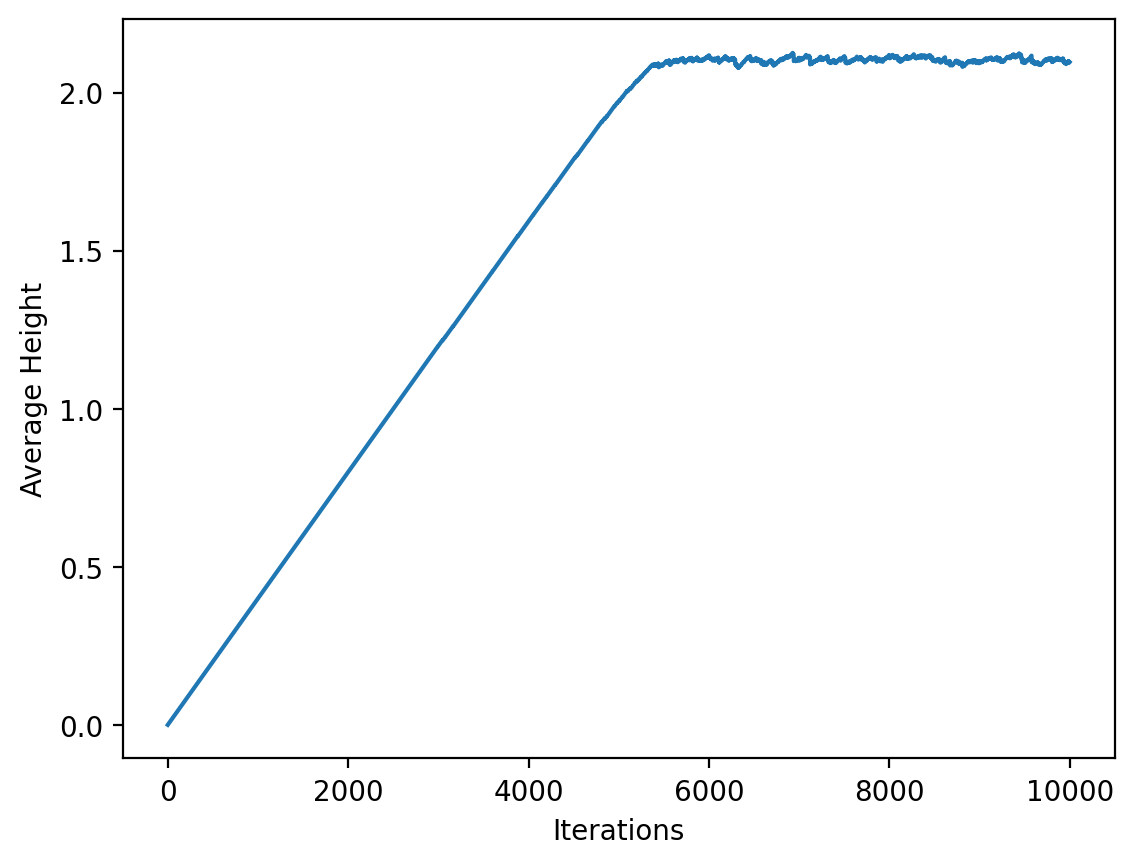

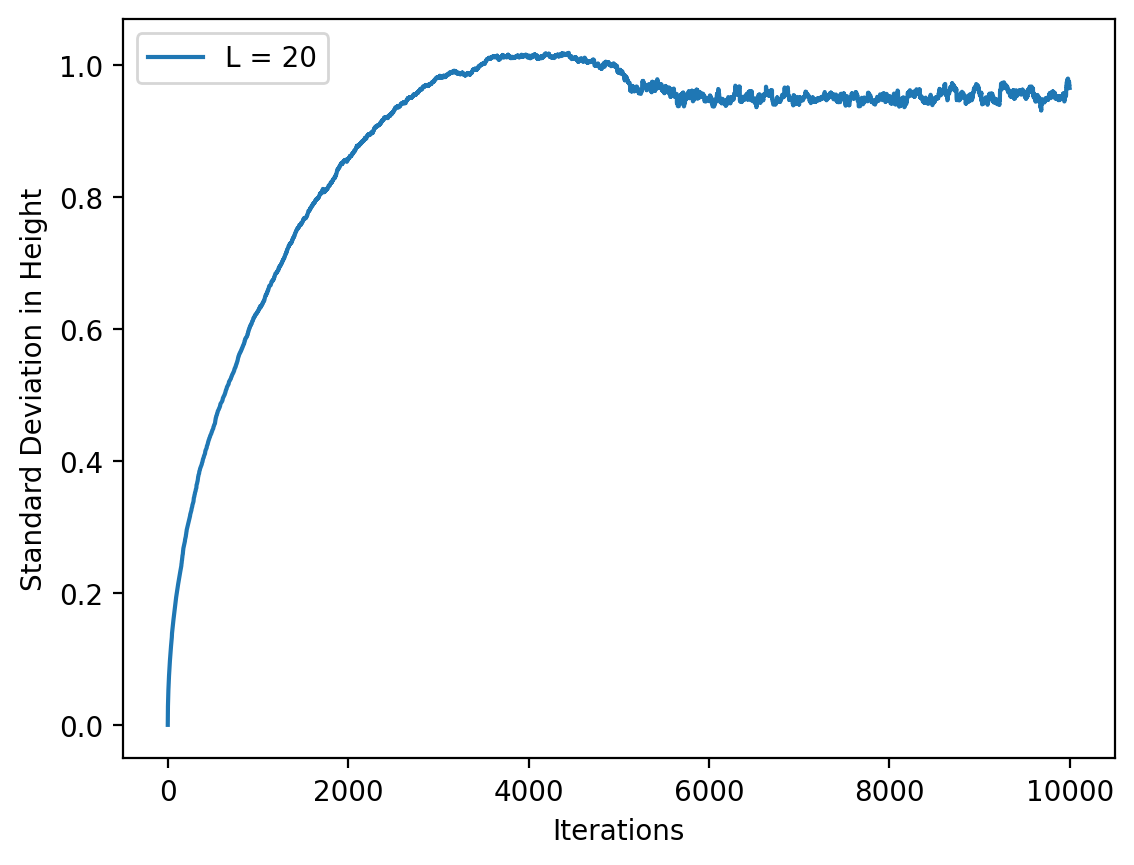

In [10]:
%matplotlib inline
plt.plot(z_avg1, label = 'L = 20')
# plt.plot(z_avg2, label = 'L = 50')
# plt.plot(z_avg3, label = 'L = 100')
plt.xlabel('Iterations')
plt.ylabel('Average Height')
# plt.legend()
plt.show()

plt.plot(z_std1, label = 'L = 20')
# plt.plot(z_std2, label = 'L = 50')
# plt.plot(z_std3, label = 'L = 100')
plt.xlabel('Iterations')
plt.ylabel('Standard Deviation in Height')
plt.legend()
plt.show()

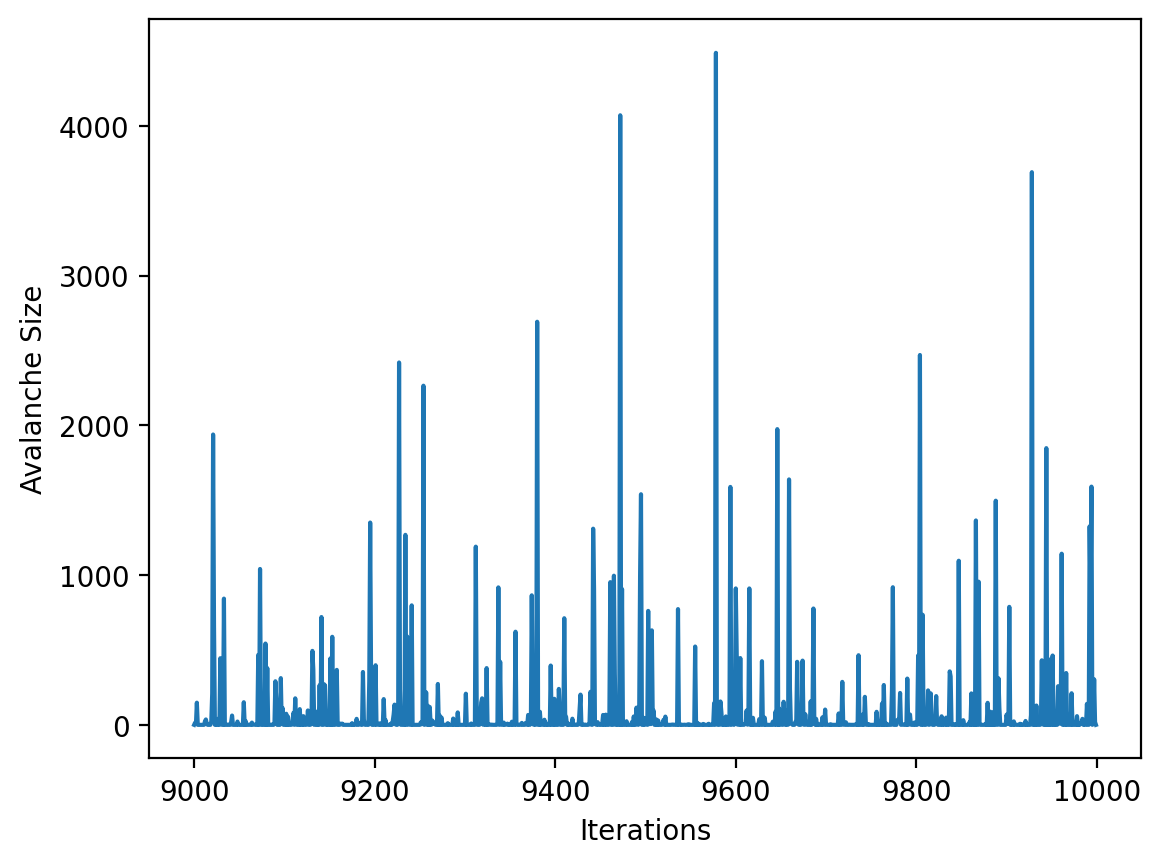

In [11]:
iterations = np.arange(9000,10000,1)
plt.plot(iterations,av_size1[9000:])
plt.xlabel('Iterations')
plt.ylabel('Avalanche Size')
# plt.legend()
plt.show()

In [12]:
bins1, dist_size1 = quants(av_size1)

In [13]:
np.max(bins1)

5476.0

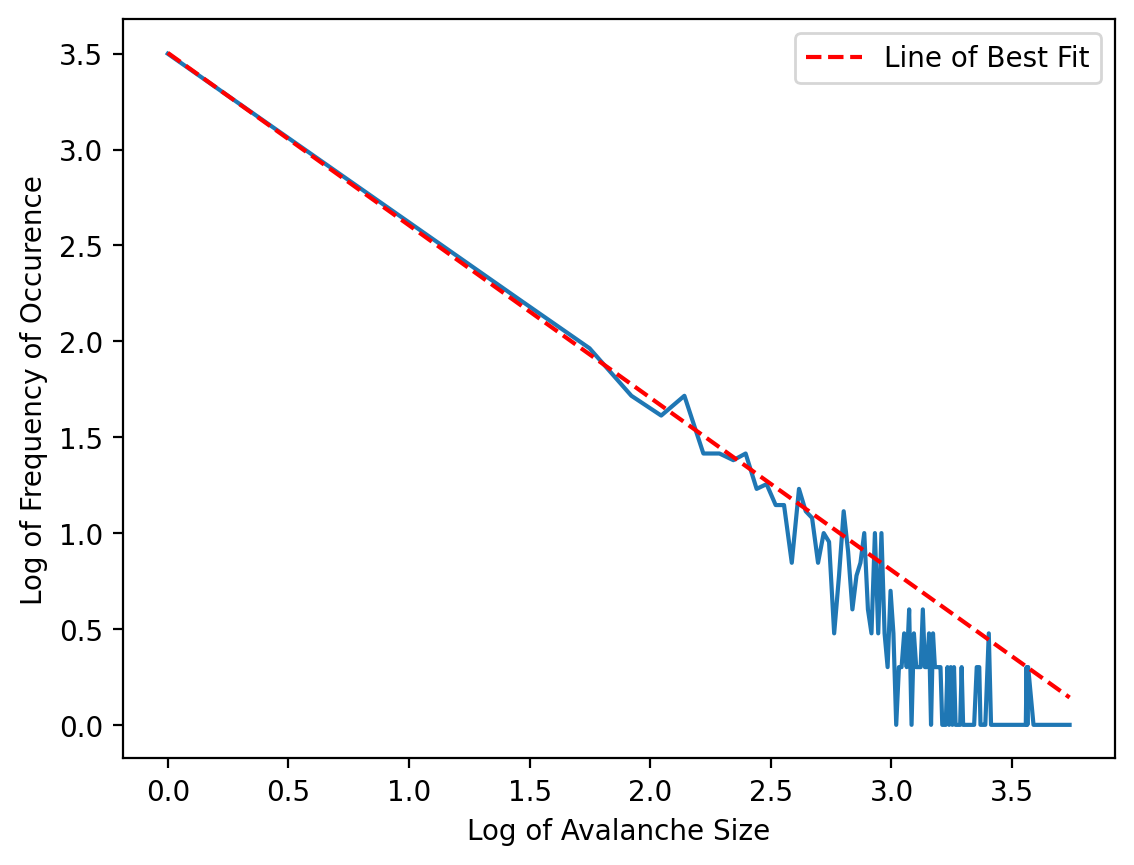

In [15]:
# nums = np.arange(1,len(dist_size1)+1,1)
plt.plot(np.log10(bins1[:]), np.log10(dist_size1[:]))
# plt.xlim(0,3)
# plt.ylim(2,5)
plt.xlabel('Log of Avalanche Size')
plt.ylabel('Log of Frequency of Occurence')
m1,c1 = np.polyfit(np.log10(bins1)[:10], np.log10(dist_size1)[:10],1)
plt.plot(np.log10(bins1[:]), m1*np.log10(bins1[:]) + c1, ls='--', color='red', label = 'Line of Best Fit')
plt.legend()
plt.show()

In [16]:
print(-m1)

0.8992460357905567


In [22]:
# @njit
def exp(L, iterations, zc, N):
    
    exp = np.zeros(N)
    
    for i in range(N):
        z, av, z_avg, z_std, av_size = simulate2(L, iterations, zc)
        bins, dist_size = quants(av_size)
        m,c = np.polyfit(np.log(bins)[1:50], np.log(dist_size)[1:50],1)
        exp[i] = -m
        
    return exp

In [17]:
def av_L(iterations, zc, N):
    
    L = np.array([int(10*(i+1)) for i in range(N)])
    avg_av_size = np.zeros(N)
    
    for i in range(N):
        z, av, z_avg, z_std, av_size = simulate3(L[i], iterations, zc)
        avg_av_size[i] = np.mean(av_size[-10000:])
    
    return L, avg_av_size

In [18]:
%%time
av_L1 = av_L(100000, 3, 10)

CPU times: total: 3min 56s
Wall time: 7min 43s


In [19]:
def analytic(L):
    T = 0
    for m in range(1,int(L+1)):
        for n in range(1,int(L+1)):
            T += ((np.tan((np.pi*m)/(2*(L+1))))**(-2))*((np.tan((np.pi*n)/(2*(L+1))))**(-2))*(((np.sin((np.pi*n)/(2*(L+1))))**2)+((np.sin((np.pi*m)/(2*(L+1))))**2))**(-1)

    T = (1/((L**2)*(L+1)**2))*T
    return T

In [20]:
analytic(1000)

43734.03901432901

In [21]:
analytic_av1 = [analytic(av_L1[0][i]) for i in range(len(av_L1[0]))]

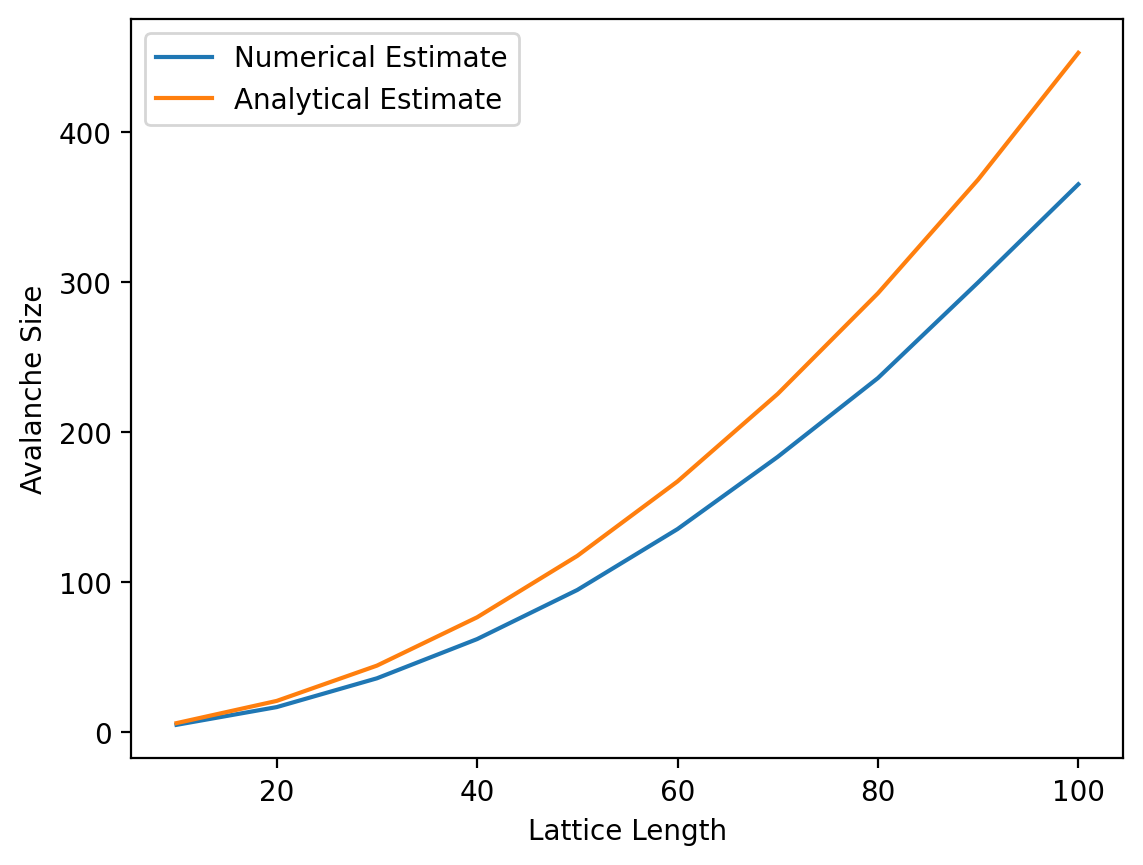

In [39]:
plt.plot(av_L1[0],av_L1[1], label = 'Numerical Estimate')
plt.plot(av_L1[0],analytic_av1, label = 'Analytical Estimate')
plt.ylabel('Avalanche Size')
plt.xlabel('Lattice Length')
plt.legend()
plt.show()

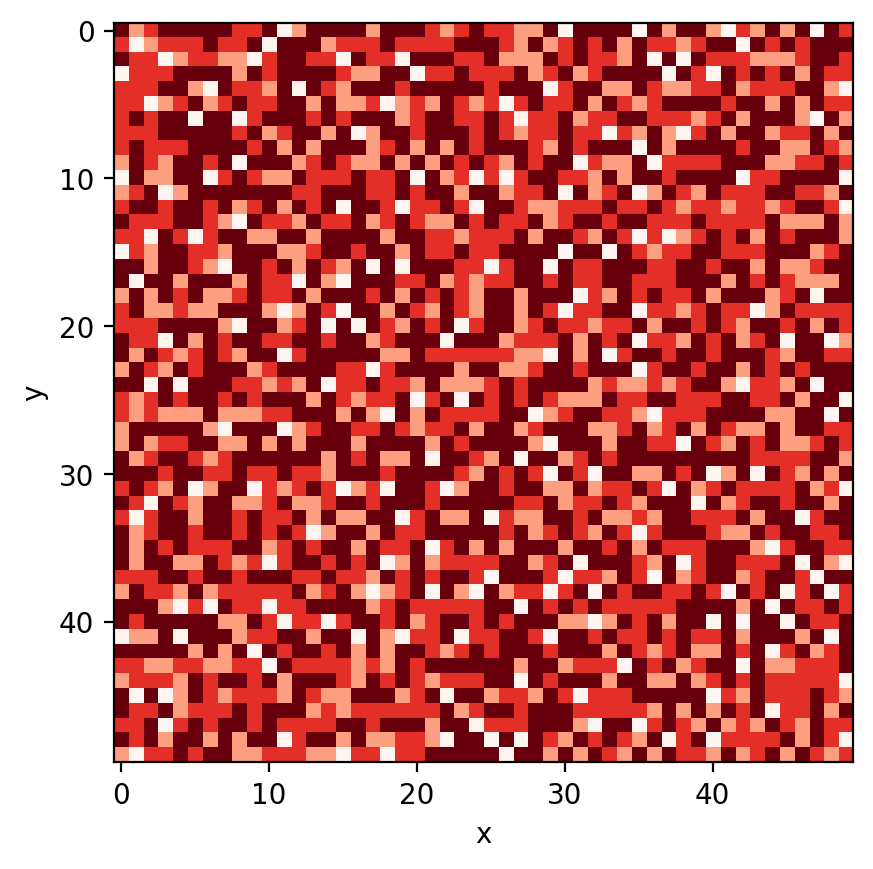

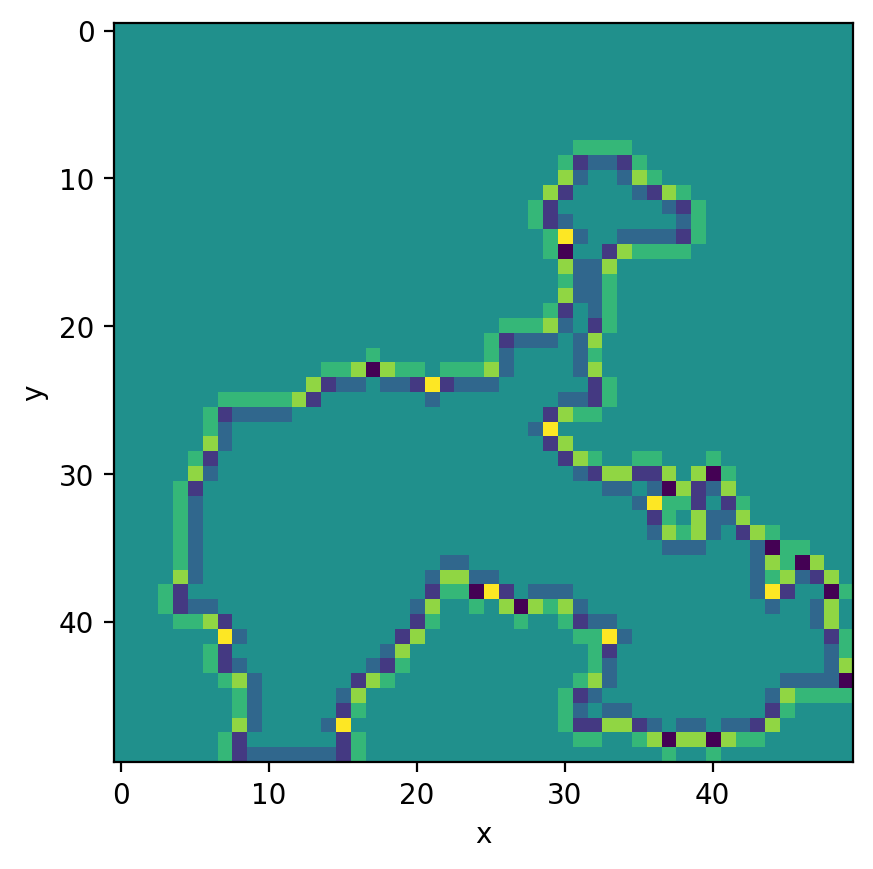

In [36]:
z_min = np.min(z1)
z_max = np.max(z1)
plt.imshow(z1[9903], cmap = 'Reds', vmin = z_min, vmax = z_max)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

z_min = np.min(av1)
z_max = np.max(av1)
plt.imshow(av1[9903], vmin = z_min, vmax = z_max)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [17]:
%%time
exp1 = exp(50, 10000, 3, 100)

CPU times: total: 3min
Wall time: 7min 54s


(array([ 2.,  2.,  6., 14., 16., 24., 22., 12.,  1.,  1.]),
 array([-1.5206908 , -1.48542935, -1.45016789, -1.41490643, -1.37964497,
        -1.34438351, -1.30912205, -1.27386059, -1.23859913, -1.20333767,
        -1.16807621]),
 <BarContainer object of 10 artists>)

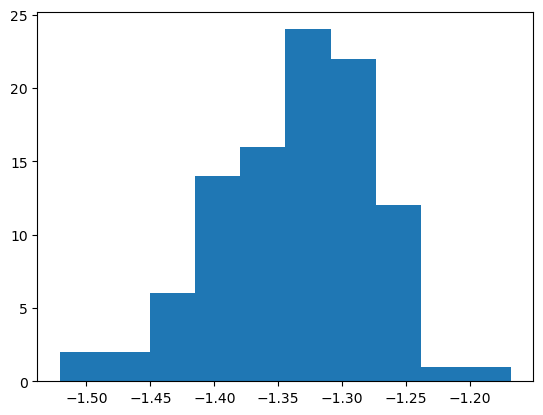

In [18]:
plt.hist(exp1)

In [19]:
np.mean(exp1)

-1.3361845919934536

CPU times: total: 172 ms
Wall time: 360 ms


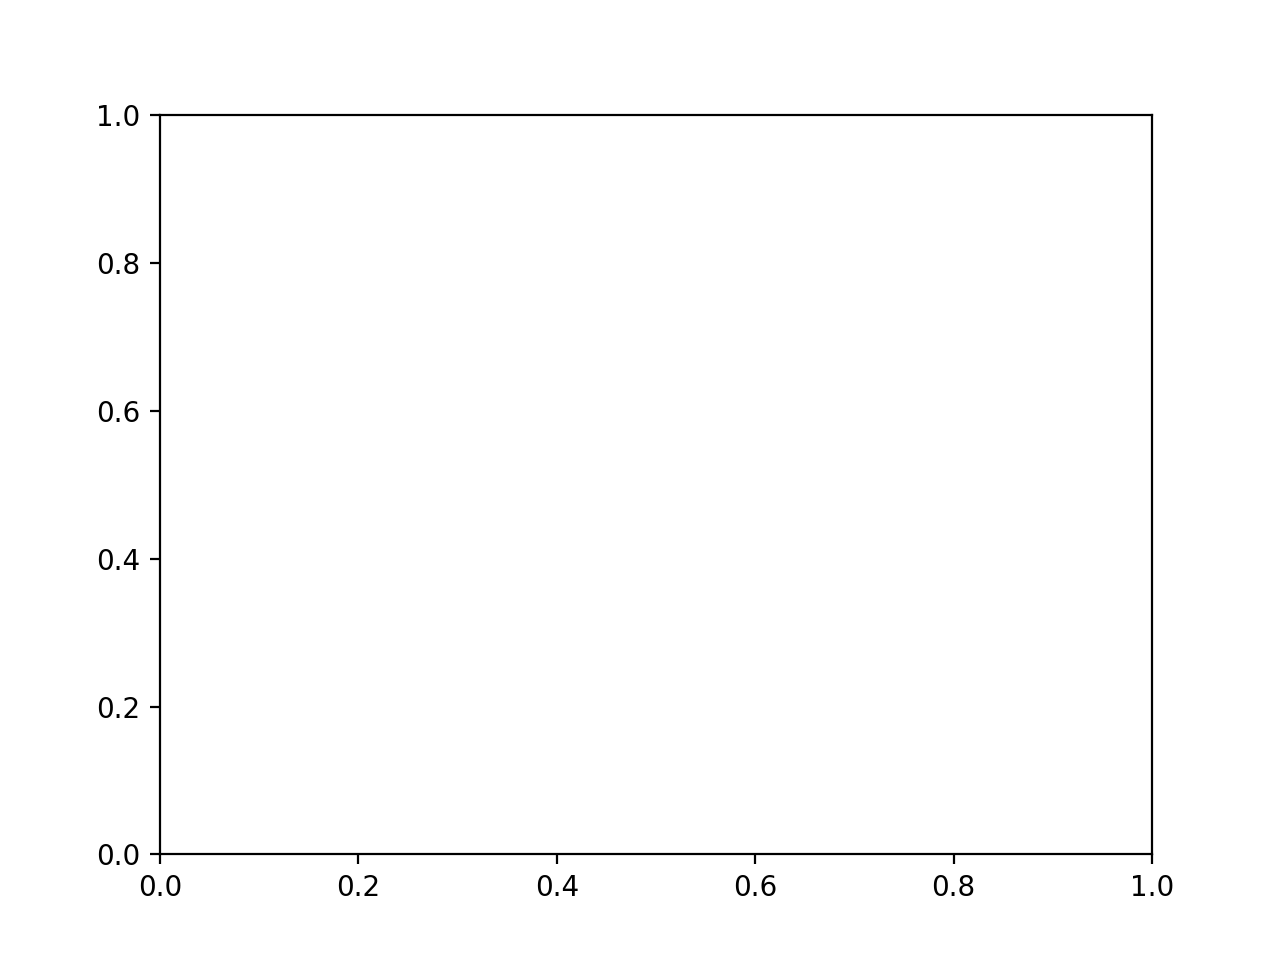

In [40]:
%%time
%matplotlib widget

fig = plt.figure()  
ax = plt.axes()

z_min = np.min(z1)
z_max = np.max(z1)

def animate(i):
    ax.clear()
    ax.imshow(z1[i+9900], cmap = 'Reds', vmin = z_min, vmax = z_max)
    ax.set_title('Iteration ' + str(i+9900))

anim = animation.FuncAnimation(fig, animate, frames = 100, interval = 200, repeat = False)
# plt.show()


# Save the animation as an animated GIF
# anim.save("sandpile_sim.gif", dpi=100, writer=PillowWriter(fps=600))

CPU times: total: 10.7 s
Wall time: 21.9 s


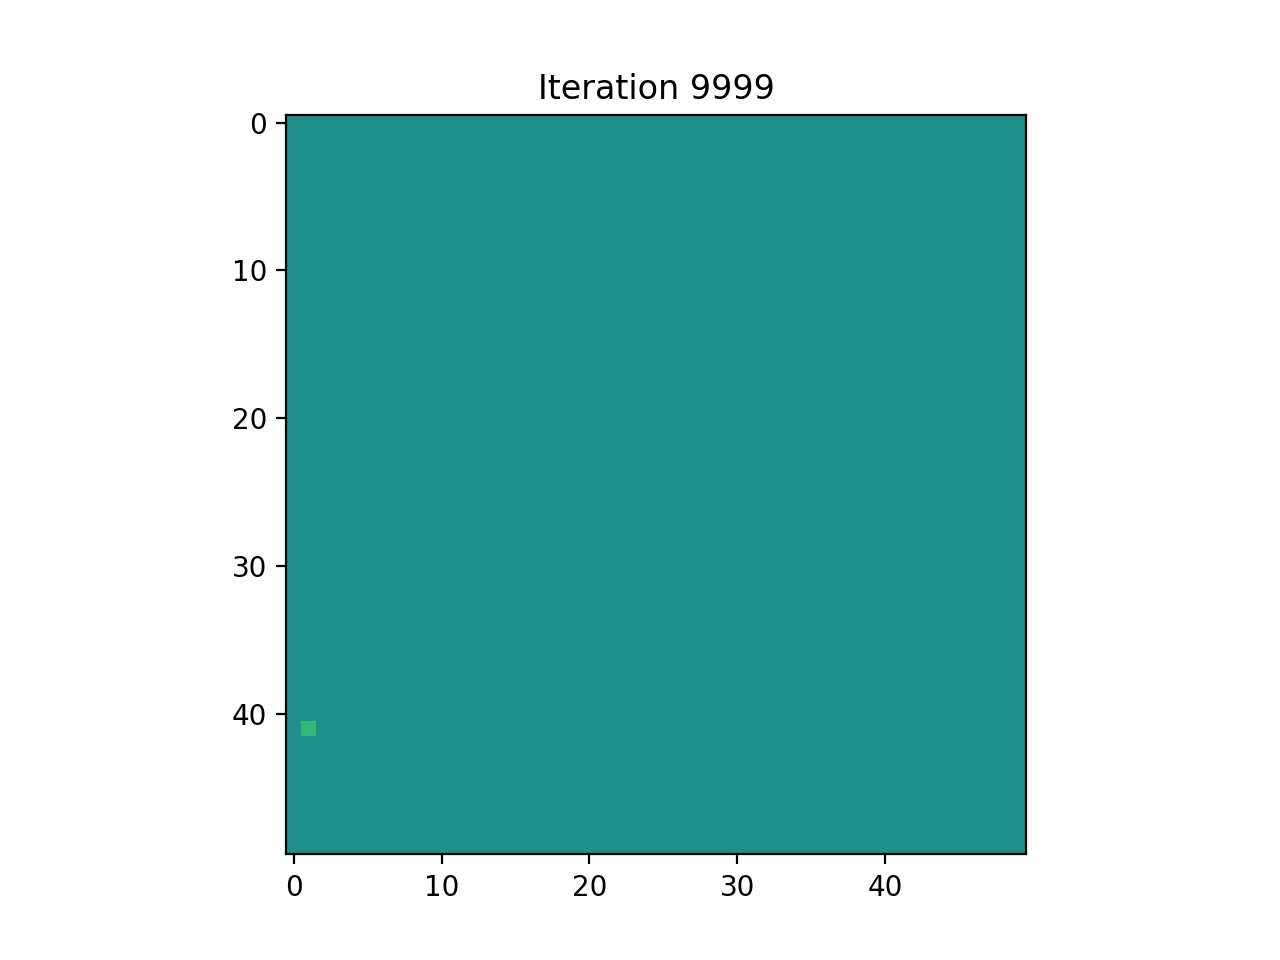

In [45]:
%%time
%matplotlib widget

fig = plt.figure()  
ax = plt.axes()

z_min = np.min(av1)
z_max = np.max(av1)

def animate(i):
    ax.clear()
    ax.imshow(av1[i+9900], vmin = z_min, vmax = z_max)
    ax.set_title('Iteration ' + str(i+9900))

anim = animation.FuncAnimation(fig, animate, frames = 100, interval = 200, repeat = False)
# plt.show()


# Save the animation as an animated GIF
anim.save("av.gif", dpi=200, writer=PillowWriter(fps=5))

In [ ]:
        # # Edges
        # for j in range(1,L-1):
        #     if z[j][-1] > zc:
        #         z[j][-1] += -4
        #         z[j-1][-1] += 1
        #         z[j+1][-1] += 1
        #         z[j][-2] += 1
        #     if z[j][1] > zc:
        #         z[j][1] += -4
        #         z[j-1][1] += 1
        #         z[j+1][1] += 1
        #         z[j][2] += 1              
        # for k in range(1,L-1):
        #     if z[-1][k] > zc:
        #         z[-1][k] += -4
        #         z[-1][k-1] += 1
        #         z[-1][k+1] += 1
        #         z[-2][k] += 1
        #     if z[1][k] > zc:
        #         z[1][k] += -4
        #         z[1][k-1] += 1
        #         z[1][k+1] += 1
        #         z[2][k] += 1

        # # Corners
        # if z[0][0] > zc:
        #     z[0][0] += 4